In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [2]:
# select stocks
res_mom = pd.read_csv('../../PB_ROE/res_mom.csv')
# first 15 stocks
res_mom_15 = res_mom.iloc[:15,:]
# to list
res_mom_15_list = res_mom_15['ts_code'].to_list()
res_mom_15_list

['002594.SZ',
 '002304.SZ',
 '000768.SZ',
 '600660.SH',
 '601788.SH',
 '000725.SZ',
 '000001.SZ',
 '601628.SH',
 '601601.SH',
 '002008.SZ',
 '600016.SH',
 '600104.SH',
 '000858.SZ',
 '600111.SH',
 '600036.SH']

In [6]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])
# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2020-01-01'
# TEST_START_DATE = '2020-01-01'
# TEST_END_DATE = '2023-01-01'
# processed = pd.read_csv('datasets/SSE_processed.csv')
TRAIN_START_DATE='2016-01-01'
TRAIN_END_DATE='2021-01-01'
TEST_START_DATE='2021-01-01'
# TEST_END_DATE='2023-01-01'
TEST_END_DATE='2023-01-01'


processed = pd.read_csv('datasets/processed_technical_indicators.csv')
ticket_list = res_mom_15_list
processed = processed[processed['tic'].isin(ticket_list)]
# sort
print(processed.shape)
# processed.sample(5)
processed.tic.value_counts()

(25545, 17)


000001.SZ    1703
000725.SZ    1703
000768.SZ    1703
000858.SZ    1703
002008.SZ    1703
002304.SZ    1703
002594.SZ    1703
600016.SH    1703
600036.SH    1703
600104.SH    1703
600111.SH    1703
600660.SH    1703
601601.SH    1703
601628.SH    1703
601788.SH    1703
Name: tic, dtype: int64

In [4]:
print(processed.columns)
print(INDICATORS)

Index(['date', 'tic', 'open', 'high', 'low', 'close', 'volume', 'day', 'macd',
       'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma',
       'close_60_sma', 'turbulence'],
      dtype='object')
['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']


In [24]:
INDICATORS.append('turnover_rate')
INDICATORS.append('pb')
INDICATORS.append('day')
INDICATORS.append('close')

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [26]:
# 重新import DRLEnsembleAgent
import importlib
# from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
importlib.reload(sys.modules['finrl.agents.stablebaselines3.models'])
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent


In [7]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5    
}

rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    # "batch_size": 128
                    "batch_size": 512
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      # "batch_size": 64
                      "batch_size": 512
                    }

timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

Stock Dimension: 15, State Space: 151


In [8]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  375.90577053030336
======Model training from:  2016-01-01 to  2021-01-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_1
-------------------------------------
| time/                 |           |
|    fps                | 62        |
|    iterations         | 100       |
|    time_elapsed       | 7         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -21.4     |
|    explained_variance | 0.357     |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 62.1      |
|    reward             | 0.6818389 |
|    std                | 1.01      |
|    value_loss         | 9.89      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 1

In [9]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-01-04,2021-04-09,DDPG,-0.243015,-0.33849,-0.24224
1,189,2021-04-09,2021-07-13,DDPG,0.046498,0.003928,0.194893
2,252,2021-07-13,2021-10-19,DDPG,-0.086774,0.085988,0.140589
3,315,2021-10-19,2022-01-17,DDPG,-0.228248,-0.285802,-0.148079
4,378,2022-01-17,2022-04-25,A2C,-0.127627,-0.232017,-0.233066
5,441,2022-04-25,2022-07-27,PPO,0.176343,0.208859,0.147883


In [8]:
df_account_value

NameError: name 'df_account_value' is not defined

(485,)
Sharpe Ratio:  0.3059642509731799


Text(0, 0.5, 'Account Value')

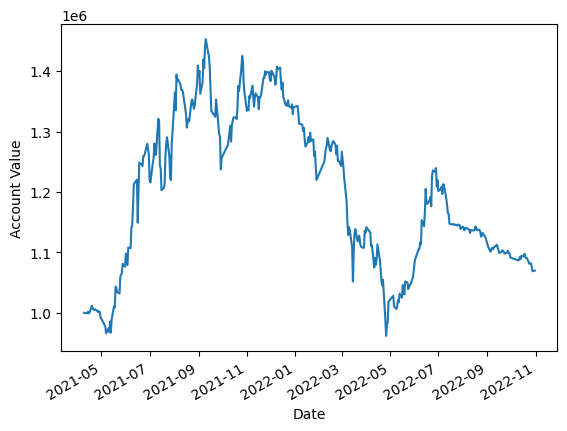

In [10]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()
print(unique_trade_date.shape)
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))
%matplotlib inline
df_account_value['date'] = pd.to_datetime(df_account_value['date'])
df_account_value.plot(x='date',y='account_value',legend=False)
plt.xlabel('Date')
plt.ylabel('Account Value')
# df_account_value.account_value.plot(xlabel='Date',ylabel='Account Value')
# set name of x axis: Date


In [11]:
new_end_date = '2022-01-01'
df_account_value = df_account_value[df_account_value['date'] <= new_end_date]

In [12]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.507250
Cumulative returns     0.340526
Annual volatility      0.279409
Sharpe ratio           1.616493
Calmar ratio           3.417008
Stability              0.696494
Max drawdown          -0.148449
Omega ratio            1.329179
Sortino ratio          2.557507
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.167628
Daily value at risk   -0.033410
dtype: float64


In [16]:
print("==============Get Baseline Stats===========")
baseline_df = pd.read_csv('../ResMom15Macro/datasets/csi300.csv')
baseline_df = baseline_df[baseline_df['date'] <= new_end_date]
stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
Annual return          0.062881
Cumulative returns     0.424122
Annual volatility      0.194388
Sharpe ratio           0.411575
Calmar ratio           0.193706
Stability              0.699828
Max drawdown          -0.324620
Omega ratio            1.076868
Sortino ratio          0.566911
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052678
Daily value at risk   -0.024173
dtype: float64


==============Compare to SSE 50 Index===========


Start date,2021-04-09
End date,2021-12-31
Total months,8
,Backtest
Annual return,50.725%
Cumulative returns,34.053%
Annual volatility,27.941%
Sharpe ratio,1.62
Calmar ratio,3.42
Stability,0.70
Max drawdown,-14.845%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.84,2021-09-10,2021-09-29,NaT,NaN
1,8.95,2021-07-12,2021-07-16,2021-08-02,16
2,6.28,2021-08-04,2021-08-17,2021-08-31,20
3,5.85,2021-06-15,2021-06-16,2021-06-18,4
4,5.02,2021-06-28,2021-07-02,2021-07-07,8


Stress Events,mean,min,max
New Normal,0.18%,-5.85%,4.96%


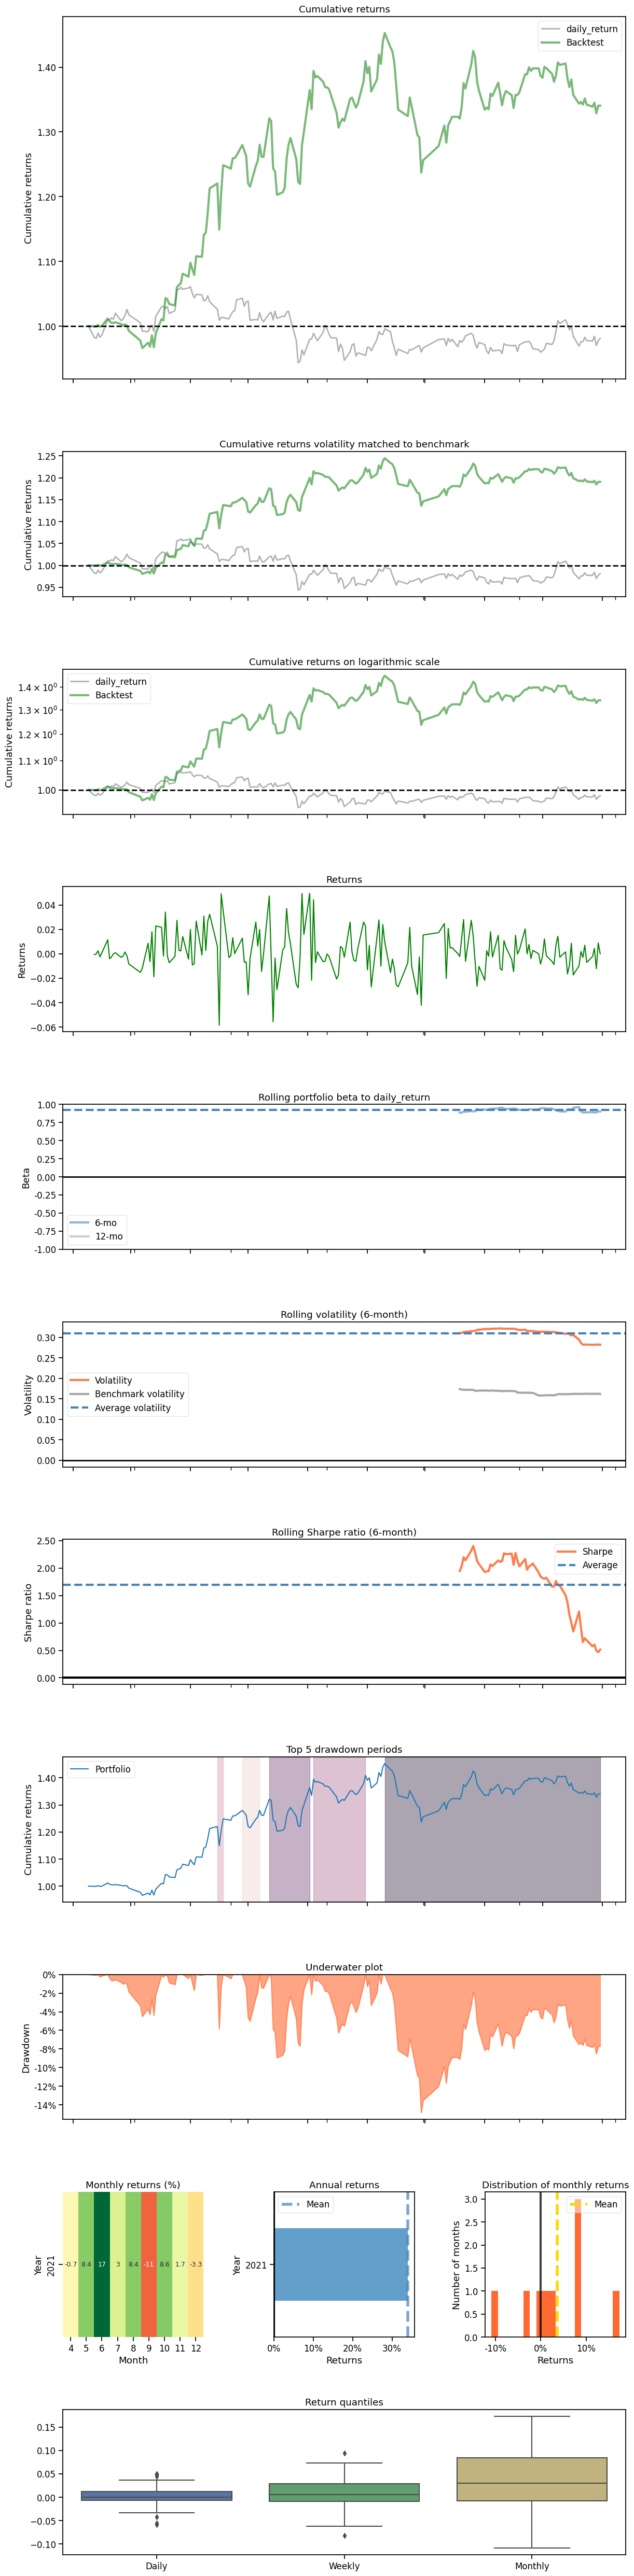

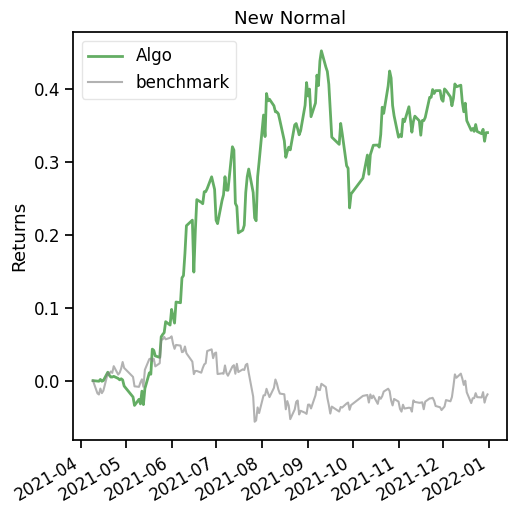

In [17]:
print("==============Compare to SSE 50 Index===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
              baseline_ticker = 'CSI300', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'], baseline_df = baseline_df)

In [39]:
total_return_rate

0.10222773167000065

In [40]:
len(df_account_value)

189

In [41]:
# 计算年化收益率

total_return_rate = df_account_value.account_value.values[-1] / 1e6  - 1
annual_return_rate = (1 + total_return_rate) ** (250 / len(df_account_value)) - 1
print('年化收益率：', annual_return_rate)

年化收益率： 0.13740324337855592


In [30]:
df_account_value.head(10)

,account_value,date,daily_return,datadate
0,1.000000e+06,2020-11-06,NaN,2020-11-06
1,1.003903e+06,2020-11-09,0.003903,2020-11-09
2,1.003663e+06,2020-11-10,-0.000239,2020-11-10
3,1.002640e+06,2020-11-11,-0.001020,2020-11-11
4,1.002187e+06,2020-11-12,-0.000452,2020-11-12
5,1.001421e+06,2020-11-13,-0.000764,2020-11-13
6,1.001776e+06,2020-11-16,0.000354,2020-11-16
7,1.000769e+06,2020-11-17,-0.001006,2020-11-17
8,9.994531e+05,2020-11-18,-0.001314,2020-11-18
9,1.003087e+06,2020-11-19,0.003636,2020-11-19


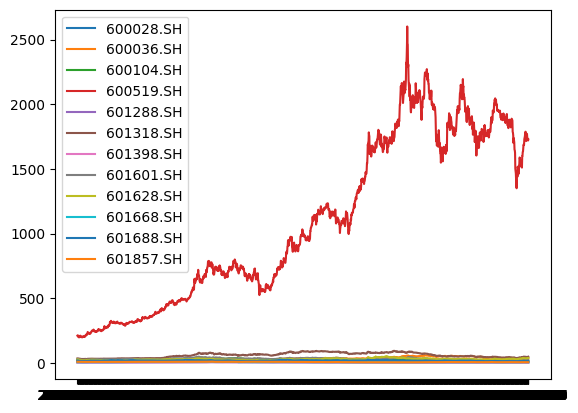

In [56]:
# 分别画出 processed 数据中每只股票的close的折线图
for i in range(len(ticket_list)):
    plt.plot(processed[processed.tic == ticket_list[i]].date, processed[processed.tic == ticket_list[i]].close)
plt.legend(ticket_list)



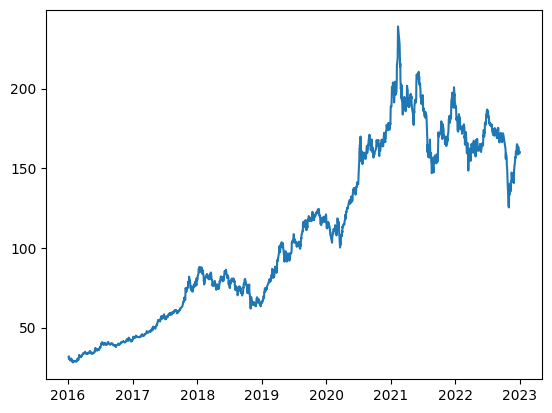

In [61]:
# 画出 processed 数据中每只股票的close的平均值的折线图，每个date只画一次
processed_mean = processed.groupby('date').mean()
processed_mean['date'] = pd.to_datetime(processed_mean.index)
plt.plot(processed_mean.date, processed_mean.close)


In [54]:
processed.groupby('date')

In [51]:
# 计算股票在每个date的体量百分比和所有股票体量的加权和



# processed['volume_pct'] = processed.groupby('date')['volume'].apply(lambda x: x / x.sum())

# plot processed 数据中的close按照股票体量的加权和 区分训练集和测试集，每个date只画一次




TypeError: Axis must be specified when shapes of a and weights differ.

Text(0.5, 23.52222222222222, 'Date')

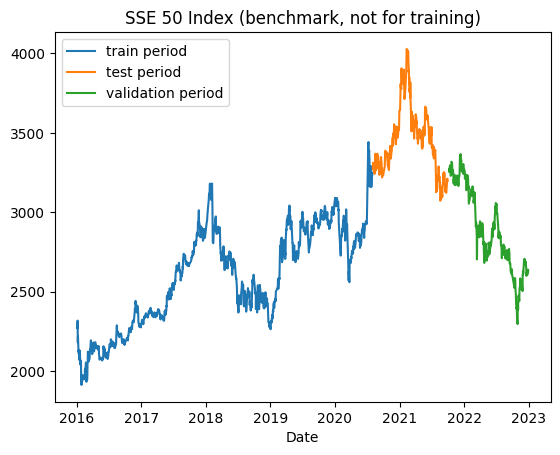

In [68]:
# plot baseline_df 数据中的close 区分训练集和测试集
plt.plot(baseline_df[baseline_df.date <= TRAIN_END_DATE].date, baseline_df[baseline_df.date <= TRAIN_END_DATE].close)
plt.plot(baseline_df[(baseline_df.date > TRAIN_END_DATE) & (baseline_df.date <= TEST_END_DATE)].date, baseline_df[(baseline_df.date > TRAIN_END_DATE) & (baseline_df.date <= TEST_END_DATE)].close)
plt.plot(baseline_df[baseline_df.date > TEST_END_DATE].date, baseline_df[baseline_df.date > TEST_END_DATE].close)
plt.legend(['train period', 'test period', 'validation period'])
plt.title('SSE 50 Index (benchmark, not for training)')
plt.savefig('outputs/SSE50IndexStock0308/SSE50Index.png')
plt.xlabel('Date')


In [48]:
processed.columns

Index(['tic', 'date', 'open', 'high', 'low', 'close', 'volume', 'day', 'macd',
       'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma',
       'close_60_sma', 'turbulence', 'turnover_rate', 'pb'],
      dtype='object')